## Initialization

In [1]:
%cd ..
import numpy as np
from tqdm.contrib.concurrent import thread_map
from itertools import repeat
import librosa

from evoaudio.base_algorithms import *
from evoaudio.sample_library import SampleLibrary
from evoaudio.population import Population
from evoaudio.population_logging import PopulationLogger
from evoaudio.individual import BaseIndividual

c:\Users\justi\coding\Uni\MA


c:\Users\justi\miniconda3\envs\ma\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample_lib = SampleLibrary()

Loading samples: 100%|██████████| 6826/6826 [00:12<00:00, 549.46it/s]


## 1+1ES for single onset

In [3]:
target_sample = sample_lib.get_random_sample_uniform()
print("Target: " + str(target_sample))
result = approximate_piece(target_y=target_sample.y, max_steps=1000, sample_lib=sample_lib, popsize=1, n_offspring=1, onset_frac=1, onsets=[0], verbose=True)

Target: (Oud, oud, ais4)


100%|██████████| 1000/1000 [00:09<00:00, 107.64it/s, Best individual: Fitness: 0.0 | (Oud, oud, ais4)]                                                                                                    


## Performance profiling

In [4]:
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=15)
%prun approximate_piece(target_y=ex, max_steps=1000, sample_lib=sample_lib, popsize=1, n_offspring=1, onset_frac=1, onsets=[0], verbose=True)

100%|██████████| 1000/1000 [00:12<00:00, 82.80it/s, Best individual: Fitness: 0.678055449695122 | (ElectricPiano, Scarbee_A200_WheresWallee, e3), (AcousticGuitar, tr113AGAPM, gis3), (ElectricGuitar, tr133EGLPM, fis2)]

         2106374 function calls (2059073 primitive calls) in 12.107 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    11770    2.434    0.000    2.434    0.000 {built-in method numpy.fft._pocketfft_internal.execute}
     1001    2.349    0.002    9.803    0.010 individual.py:30(calc_abs_stft)
     1002    2.273    0.002    5.700    0.006 spectrum.py:45(stft)
    17585    1.070    0.000    1.070    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     8973    0.505    0.000    0.505    0.000 {method 'acquire' of '_thread.lock' objects}
     5911    0.371    0.000    0.655    0.000 arraypad.py:86(_pad_simple)
    11675    0.327    0.000    0.446    0.000 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
     5911    0.275    0.000    0.275    0.000 {built-in method numpy.empty}
     1001    0.153    0.000   10.323    0.010 fitness.py:36(fitness_cached)
     5911    0.139    0.000    0.145    0.000 arraypad.py:1

List comprehension method is slower than for-loop:

In [5]:
from evoaudio.population import Population
from evoaudio.fitness import multi_onset_fitness_cached
from evoaudio.base_algorithms import _init_population

ex, _ = librosa.load(librosa.ex('nutcracker'), duration=15)
target = Target(ex)
pop = _init_population(sample_lib, target, 1, 100, False)
for individual in pop.individuals:
    individual.recalc_fitness = True 
def a():
    for individual in pop.individuals:
        multi_onset_fitness_cached(target, individual)
        individual.calc_phi_fitness()
def b(target, individual):
    multi_onset_fitness_cached(target, individual)
    individual.calc_phi_fitness()
def c():
    [b(target, individual) for individual in pop.individuals]
%timeit a()
for individual in pop.individuals:
    individual.recalc_fitness = True 
%timeit c()

c:\Users\justi\miniconda3\envs\ma\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=510
  warnings.warn(


2.58 ms ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.71 ms ± 50.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
ex_stft = librosa.stft(ex)
abs_stft = abs(ex_stft)
%timeit librosa.stft(ex)
%timeit np.abs(ex_stft)
%timeit np.average(abs_stft, axis=1)

9.17 ms ± 59.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.81 ms ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
76.4 µs ± 357 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Copy operation optimization

In [5]:
from copy import deepcopy
from evoaudio.individual import BaseIndividual
from evoaudio.mutations import Mutator
individual_1 = BaseIndividual.create_multi_onset_individual(np.array([0, 100]), 1, sample_lib)
mutator = Mutator(sample_lib)
print(individual_1)
temp_ind = deepcopy(individual_1)
individual_2 = mutator.mutate_individual(temp_ind)
print(individual_1)
print(individual_2)

[(ElectricGuitar, tr131EGLFM, c4), (Violin, tr151VNNVM, fis6), (Viola, tr163VLNVM, fis4)], [(AcousticGuitar, tr111AGRPM, c5), (Cello, tr171VCNOM, b2), (Flute, tr332FLVIM, fis6), (AcousticGuitar, tr113AGAPM, b4)]
[(ElectricGuitar, tr131EGLFM, c4), (Violin, tr151VNNVM, fis6), (Viola, tr163VLNVM, fis4)], [(AcousticGuitar, tr111AGRPM, c5), (Cello, tr171VCNOM, b2), (Flute, tr332FLVIM, fis6), (AcousticGuitar, tr113AGAPM, b4)]
[(ElectricGuitar, tr131EGLFM, c4), (Violin, tr151VNNVM, fis6), (Viola, tr163VLNVM, fis4), (Violin, tr153VNNVM, ais3)], [(AcousticGuitar, tr111AGRPM, c5), (Cello, tr171VCNOM, b2), (Flute, tr332FLVIM, fis6), (AcousticGuitar, tr113AGAPM, d5)]


In [6]:
from evoaudio.individual import SampleCollection
individual_1 = BaseIndividual.create_multi_onset_individual(np.array([0, 100]), 1, sample_lib)
sample_1 = individual_1.sample_collections[0]
sample_2 = SampleCollection.from_copy(sample_1)
print(sample_1)
print(sample_2)
mutator.mutate_pitch(sample_2)
print(sample_1)
print(sample_2)

(Cello, tr173VCNVM, e4), (Flute, tr332FLVIM, f4), (Flute, tr332FLNOM, e4)
(Cello, tr173VCNVM, e4), (Flute, tr332FLVIM, f4), (Flute, tr332FLNOM, e4)
(Cello, tr173VCNVM, e4), (Flute, tr332FLVIM, f4), (Flute, tr332FLNOM, e4)
(Cello, tr173VCNVM, e4), (Flute, tr332FLVIM, a4), (Flute, tr332FLNOM, e4)


In [10]:
%timeit deepcopy(individual_1)
%timeit BaseIndividual.from_copy(individual_1)

194 µs ± 2.19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
19.8 µs ± 87.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Full Population Testing

In [3]:
MAX_STEPS = 100
ONSET_FRAC = 0.1
POPSIZE = 100
N_OFFSPRING = 1

In [4]:
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=30)
result = approximate_piece(target_y=ex, max_steps=MAX_STEPS, sample_lib=sample_lib, onset_frac=ONSET_FRAC, popsize=POPSIZE, n_offspring=N_OFFSPRING)

100%|██████████| 3000/3000 [00:54<00:00, 55.08it/s, Best individual: Contained samples: (ElectricPiano, Scarbee_Pianet_DI, 52), (AcousticGuitar, tr113AGAFM, 61), (Piano, tr011PFNOM, 71), (TAMPURA_P_AND_BROTHERS, tampura, 43), (TAMPURA_P_AND_BROTHERS, tampura, 42) | Fitness: 1.6478075151077962]


In [9]:
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=30)
result = approximate_piece(target_y=ex, max_steps=MAX_STEPS, sample_lib=sample_lib, onset_frac=ONSET_FRAC, popsize=POPSIZE, n_offspring=N_OFFSPRING)

100%|██████████| 30000/30000 [13:41<00:00, 36.54it/s, 																																																																																																				Best individual: [Onset: 318976 | (Piano, The_Gentleman, f7), (Piano, The_Gentleman, d4), (AcousticGuitar, tr112AGAFM, gis2), (BANJO_FRAMUS, banjo_framus, dis5) | Fitness: 2.8275564500762194], [Onset: 614912 | (AcousticGuitar, tr112AGAFM, gis2), (TURKEY_SAZ, turkey_saz, fis4), (AcousticGuitar, tr113AGRFM, g4), (SHAKUHACHI_KEY, shakuhachi, b3) | Fitness: 1.4497013147865854], [Onset: 594432 | (AcousticGuitar, tr111AGRPM, cis3), (Bass, Basses_Essential, cis4), (PINKILLO_KEY, pinkillo, g5), (BANJO_FRAMUS, banjo_framus, ais2) | Fitness: 3.7699666539634147], [Onset: 125952 | (AcousticGuitar, tr111AGRFM, d5) | Fitness: 2.104592225609756], [Onset: 163328 | (AcousticGuitar, tr111AGRFM, e2) | Fitness: 3.8078125], [Onset: 259584 | (Cello, tr171VCNOM, f4), (ElectricGuitar, tr132EGVFM, dis4), (AcousticGuitar, tr111AGAFM, fis4) | Fitness: 2.9914062

In [4]:
# Logging test
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=30)
logger = PopulationLogger()
mutator = Mutator(sample_library=sample_lib, l_bound=1, u_bound=1)
result = approximate_piece(target_y=ex, max_steps=MAX_STEPS, sample_lib=sample_lib, onset_frac=ONSET_FRAC, popsize=POPSIZE, n_offspring=N_OFFSPRING, mutator=mutator, logger=logger)

100%|██████████| 100/100 [00:01<00:00, 61.27it/s, Best individual: Fitness: 2.8740202730291813 | (SHAKUHACHI_KEY, shakuhachi, e4), (Viola, tr161VLSOM, f5), (Trombone, BassTrombone_SessionHornsPro, e1), (Tuba, Tuba_Essential, a0), (Flute, tr332FLNOM, e6)]


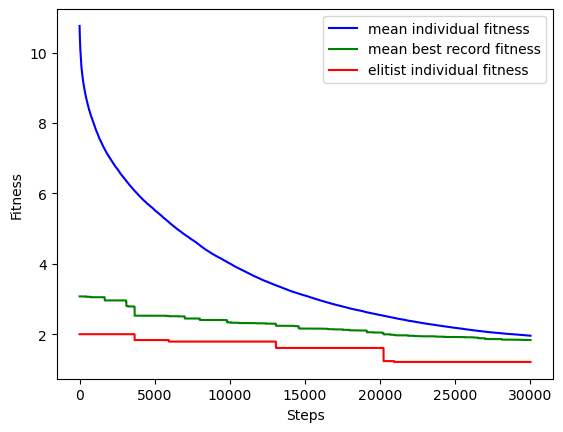

In [7]:
import matplotlib.pyplot as plt
plt.plot(logger.logged_steps, logger.mean_fitness, "b", label="mean individual fitness")
plt.plot(logger.logged_steps, logger.mean_fitness_best_records, "g", label="mean best record fitness")
plt.plot(logger.logged_steps, logger.elitist_fitness, "r", label="elitist individual fitness")
plt.xlabel("Steps")
plt.ylabel("Fitness")
#plt.ylim((4, 10))
plt.legend()


In [8]:
print(result)

Fitness: 1.2111242037783099 | (AcousticGuitar, tr113AGAPM, f4), (Bassoon, Bassoons_Essential, a1), (OUD, oud, fis2), (Clarinet, Clarinets_Essential, f3)
Fitness: 1.2111242037783099 | (AcousticGuitar, tr113AGAPM, b4), (Bassoon, Bassoons_Essential, a1), (OUD, oud, fis2), (Clarinet, Clarinets_Essential, f3)
Fitness: 1.2255616425304878 | (AcousticGuitar, tr113AGAPM, a4), (Piano, The_Grandeur, a1), (ElectricPiano, Scarbee_A200_WheresWallee, g2), (Clarinet, Clarinets_Essential, dis3)
Fitness: 1.2339836094022214 | (AcousticGuitar, tr113AGAPM, c4), (Piano, The_Grandeur, dis1), (OUD, oud, g2), (Clarinet, Clarinets_Essential, f3)
Fitness: 1.2339836094022214 | (AcousticGuitar, tr113AGAPM, b4), (Piano, The_Grandeur, a1), (OUD, oud, e3), (Clarinet, Clarinets_Essential, fis3)
Fitness: 1.2339836094022214 | (AcousticGuitar, tr113AGAPM, ais4), (Piano, The_Grandeur, a1), (OUD, oud, g2), (Clarinet, Clarinets_Essential, f3)
Fitness: 1.2339836094022214 | (AcousticGuitar, tr113AGAPM, b4), (Piano, The_Grande

In [5]:
result.save_as_file(filename="unflattened.pkl", flatten=False)

In [7]:
result.save_as_file(filename="flattened.pkl", flatten=True)

KeyboardInterrupt: 

In [5]:
pop = Population.from_file("flattened.pkl", expand=True, sample_lib=sample_lib)
print(pop)

Fitness: 2.8740202730291813 | (SHAKUHACHI_KEY, shakuhachi, e4), (Viola, tr161VLSOM, f5), (Trombone, BassTrombone_SessionHornsPro, e1), (Tuba, Tuba_Essential, a0), (Flute, tr332FLNOM, e6)
Fitness: 3.188585039198607 | (TANBUR, tanbur, g1), (CUMBUS_OPEN_STRINGS, cumbus, f3), (Flute, tr331FLVIM, gis4)
Fitness: 4.196045704486063 | (MORIN_KHUUR_VIOLIN_KEY, morin_khuur_violin, gis3), (ElectricBass, Scarbee_PreBass, f2), (ElectricPiano, Scarbee_MarkI_PinkPlayboy, cis2)
Fitness: 4.520310050087108 | (MORIN_KHUUR_VIOLIN_KEY, morin_khuur_violin, gis3), (ElectricBass, Scarbee_PreBass, f2), (Violin, Violins2_Essential, a3), (ElectricPiano, Scarbee_MarkI_PinkPlayboy, cis2)
Fitness: 5.03653667383493 | (Trombone, Trombones_Essential, gis1), (EGYPTIAN_FIDDLE, egyptian_fiddle, d3), (CEYLON_GUITAR, ceylon_guitar, ais3), (ElectricGuitar, tr131EGLPM, fis4)
Fitness: 5.03653667383493 | (Trombone, Trombones_Essential, g1), (EGYPTIAN_FIDDLE, egyptian_fiddle, d3), (CEYLON_GUITAR, ceylon_guitar, ais3), (ElectricG

In [6]:
result.save_as_file("100k_gen_nutcracker.pkl")

In [9]:
share = [collection for collection in result.get_best_individual().sample_collections.values() if collection == result.best_collections_per_onset[collection.onset]]
len(share)
distances = [collection.fitness - result.best_collections_per_onset[collection.onset].fitness for collection in result.get_best_individual().sample_collections.values()]
distances

[0.46825254858993903,
 0.3361691358612804,
 0.24772889672256104,
 0.31907774390243904,
 0.17839307831554874,
 0.2607624333079268,
 0.596325743140244]

In [10]:
print("\n".join([str(collection) for collection in result.best_collections_per_onset.values()])) # g = 100000

Onset: 566784 | (TANBUR, tanbur, a3), (Bass, Basses_SessionStringsPro, d3), (Trumpet, tr211TRNOM, cis6), (AcousticGuitar, tr113AGRFM, cis3) | Fitness: 5.376290967987805
Onset: 236032 | (PINKILLO_KEY, pinkillo, g6), (MORIN_KHUUR_VIOLIN_KEY, morin_khuur_violin, e4), (ElectricPiano, Scarbee_A200_WheresWallee, a6), (Piano, tr011PFPEM, e3) | Fitness: 4.812985423018293
Onset: 301568 | (Flute, trFltnvib, fis5), (Violin, tr151VNSOM, gis4), (Flute, trFltnvib, e5) | Fitness: 4.300095750762195
Onset: 248320 | (Flute, tr332FLNOM, cis6), (Piano, tr011PFPEM, e5), (BANJO_FRAMUS, banjo_framus, f4) | Fitness: 5.184166825457317
Onset: 384512 | (FUJARA_KEY, fujara, e6), (AcousticGuitar, tr112AGAFM, c4), (Bass, Basses_SessionStringsPro, c1), (SHAKUHACHI_KEY, shakuhachi, b5) | Fitness: 5.23088700457317
Onset: 507904 | (Flute, trflute.novib.mf, gis5), (DUNG_DKAR_TRUMPET_KEY, dung_dkar_trumpet, c5), (Trombone, BassTrombone_SessionHornsPro, fis1) | Fitness: 2.685064786585366
Onset: 242176 | (Piano, The_Giant_

In [19]:
print("Total onsets:" + str(len(result.best_collections_per_onset)))
threshold = 2
bad_onsets = [onset for onset in result.best_collections_per_onset if result.best_collections_per_onset[onset].fitness > threshold]
print("Poorly approximated onsets: " + str(len(bad_onsets)))
occurrences = []
for onset in bad_onsets:
    occurrences = [ind for ind in result.individuals if onset in ind.sample_collections]
# coll = [ind for ind in result.individuals if 372224 in ind.sample_collections or 638976 in ind.sample_collections or 538112 in ind.sample_collections]
# len(coll)
print("Occurrences of the bad onsets in the final population: " + str(len(occurrences)))

Total onsets:63
Poorly approximated onsets: 54
Occurrences of the bad onsets in the final population: 0


In [10]:
print("\n".join([str(collection) for collection in result.best_collections_per_onset.values()])) # g = 30000

Onset: 212480 | (AcousticGuitar, tr113AGRFM, ais3), (FUJARA_KEY, fujara, dis4), (AcousticGuitar, tr113AGAFM, g2) | Fitness: 1.7776495807926829
Onset: 259584 | (ElectricBass, Scarbee_Rickenbacker_Bass_Crunsher, fis3), (AcousticGuitar, tr111AGRFM, fis4), (Bassoon, Bassoons_Essential, g2) | Fitness: 1.6483517530487806
Onset: 414720 | (AcousticGuitar, tr111AGAPM, cis5), (ElectricPiano, Scarbee_A200_WheresWallee, e3), (Viola, tr162VLNOM, dis3) | Fitness: 2.1652405678353657
Onset: 372224 | (AcousticGuitar, tr112AGRFM, a3), (PINKILLO_KEY, pinkillo, d5), (DALLAPE_ACCORDION_KEY, dallape_accordion, d2), (PANFLUTE_KEY, panflute, a2) | Fitness: 17.39076219512195
Onset: 566784 | (AcousticGuitar, tr113AGAFM, g2), (ElectricBass, Scarbee_JayBass_Slap_Neck, g3), (Trombone, BassTrombone_SessionHornsPro, gis1) | Fitness: 2.794596512957317
Onset: 342528 | (Flute, tr331FLVIM, cis4), (Flute, trFltnvib, a4) | Fitness: 8.320756478658536
Onset: 366080 | (Bassoon, Bassoons_Essential, dis3), (Flute, tr332FLNOM, 

In [7]:
print("\n".join([str(collection) for collection in result.best_collections_per_onset.values()])) # g = 3000

Onset: 372224 | (Trumpet, tr211TRVIM, e3), (Violin, Violins_SessionStringsPro, c7) | Fitness: 18.096575838414633
Onset: 490496 | (AcousticGuitar, tr112AGRPM, e2), (SITAR_KEY, sitar, gis4), (Violin, tr152VNNVM, a4) | Fitness: 8.062132240853659
Onset: 62976 | (Piano, tr011PFNOM, dis5), (AcousticGuitar, tr113AGAFM, cis4) | Fitness: 2.854128239329268
Onset: 460800 | (AcousticGuitar, tr112AGAFM, gis3), (Piano, The_Giant_soft, dis7), (SHAKUHACHI_KEY, shakuhachi, cis5) | Fitness: 3.379405011432927
Onset: 614912 | (MORIN_KHUUR_VIOLIN_KEY, morin_khuur_violin, b4), (AcousticGuitar, tr112AGRPM, g3), (DUNG_DKAR_TRUMPET_KEY, dung_dkar_trumpet, c5) | Fitness: 2.8543564214939026
Onset: 519680 | (CEYLON_GUITAR, ceylon_guitar, d2), (Violin, tr152VNNOM, a5), (Flute, trflute.novib.mf, dis5), (BOUZOUKI_SAKIS_KEY, boizouki, ais4), (KANTELE_LOW_WIDE_RANGE, kantele, dis5) | Fitness: 8.205895579268292
Onset: 236032 | (ERHU_KEY, erhu_key, ais4), (Flute, tr332FLNOM, d6), (Flute, trFltnvib, d4), (UKULELE_KEY, uk

In [11]:
result.save_as_file("30k_gen_nutcracker.pkl")

In [2]:
loaded = Population.from_file("test.pkl")

Multithreading POC

In [21]:
def single_step(population:Population, n_offspring:int, target:Target, mutator:Mutator):
    # Create lambda offspring
    parents = np.random.choice(len(population.individuals), size=n_offspring)
    offspring = [mutator.mutate_individual(BaseIndividual.from_copy(population.individuals[individual_idx])) for individual_idx in parents]
    
    # Evaluate fitness of offspring
    for individual in offspring:
        individual.fitness = multi_onset_fitness_cached(target, individual)
        # Insert individual into population
        population.insert_individual(individual)
    
    # Remove lambda worst individuals
    population.remove_worst(n_offspring)

    # Update progress bar
    #pbar.set_postfix_str('\t' * 100 + f"Best individual: {str(population.get_best_individual())}")

def approximate_piece_multithreaded(target_y:Union[np.ndarray, list], max_steps:int, sample_lib:SampleLibrary, popsize:int, n_offspring:int, onset_frac:float, n_threads:int) -> Population:
    """Evolutionary approximation of a polyphonic musical piece

    Parameters
    ----------
    target_y : Union[np.ndarray, list]
        signal of the target musical piece, as imported by librosa
    max_steps : int
        Maximum number of iterations (generations) before termination
    sample_lib : SampleLibrary
        Library of samples which define the algorithm's search space
    popsize : int
        Size of the population (µ)
    n_offspring : int
        Number of offspring (λ) per generation 
    onset_frac : float
        Fraction of approximated onsets (φ) per individual

    Returns
    -------
    Population
        The full population of individual approximations after max_steps of iterations
    """
    # Initialization
    mutator = Mutator(sample_lib) # Applies mutations and handles stft updates
    target = Target(target_y)

    # Create initial population
    population = Population()
    population.individuals = [BaseIndividual.create_multi_onset_individual(target.onsets, onset_frac, sample_lib) for _ in tqdm(range(popsize), desc="Initializing Population")]
    def fitness_init(individual):
        individual.fitness = multi_onset_fitness_cached(target, individual)
    thread_map(fitness_init, population.individuals, max_workers=n_threads, desc="Calculating initial fitness")
    # for individual in tqdm(population.individuals, desc="Calculating initial fitness"):
    #     # Calc initial fitness
    #     individual.fitness = multi_onset_fitness_cached(target, individual)
    population.calc_best_fitnesses_per_onset() # Initial record of best approximations of each onset
    population.sort_individuals_by_fitness() # Sort population for easier management

    # Evolutionary Loop
    thread_map(single_step, repeat(population, max_steps), repeat(n_offspring, max_steps), repeat(target, max_steps), repeat(mutator, max_steps), max_workers=n_threads, chunksize=1)
    # for step in (pbar := tqdm(range(max_steps))):
    #     # Create lambda offspring
    #     parents = np.random.choice(population.individuals, size=n_offspring)
    #     offspring = [mutator.mutate_individual(BaseIndividual.from_copy(individual)) for individual in parents]
        
    #     # Evaluate fitness of offspring
    #     for individual in offspring:
    #         individual.fitness = multi_onset_fitness_cached(target, individual)
    #         # Insert individual into population
    #         population.insert_individual(individual)
        
    #     # Remove lambda worst individuals
    #     population.remove_worst(n_offspring)

    #     # Update progress bar
    #     pbar.set_postfix_str('\t' * 100 + f"Best individual: {str(population.get_best_individual())}")

    # Return final population
    return population
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=30)
result = approximate_piece_multithreaded(ex, MAX_STEPS, sample_lib, POPSIZE, N_OFFSPRING, ONSET_FRAC, n_threads=4)

100%|██████████| 30000/30000 [06:44<00:00, 74.10it/s] 


Notes: The threaded implementation leads to incorrect results as of right now, with n_threads multiples of some individuals within the final pop.

## Multiprocessing with subpopulations